<img src="media/CC-BY-NC-ND.png" alt="Drawing" style="width: 150px;"/> 

**Auteur** : Christophe Jorssen

Bienvenue dans cette activité informatique. Je te propose ici d'utiliser le langage Python et quelques unes de ses bibliothèques scientifiques. Peut-être n'as-tu jamais utilisé le langage Python ou peut-être même n'as-tu que très rarement programmé. Ce n'est pas grave : je vais te guider pas à pas.

Commence par exécuter la cellule suivante sans te soucier du contenu. Tu te rappelles : il suffit de sélectionner la cellule et d'appuyer sur <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (ou <kbd>MAJ</kbd>+<kbd>ENTRÉE</kbd>). Tu vas voir apparaître une figure qui correspond à la trajectoire d'un point matériel en chute libre, animé d'une vitesse initiale de norme $v_0$ et dont la direction forme un angle $\alpha_0$ avec l'horizontale. Tu pourras faire varier les valeurs de $v_0$ et de $\alpha_0$ à l'aide de curseur.

La suite sera consacrée au décorticage du code.

In [1]:
%matplotlib notebook
from ipywidgets import interact

import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

g = 9.81 # m/s²

def solve(v0 = 10.0, alpha0 = 45):
    alpha0 = alpha0 * np.pi / 180
    
    def loi_de_newton(dAdt, t):
        x = dAdt[0] ; vx = dAdt[1] ; z = dAdt[2] ; vz = dAdt[3]
        return [vx, 0, vz, -g]
    
    dAdt0 = [0, v0 * np.cos(alpha0), 0, v0 * np.sin(alpha0)]
    
    t = np.linspace(0, 5, 500)
    
    sol = odeint(loi_de_newton, dAdt0, t)

    x = sol[:, 0]
    z = sol[:, 2]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 12)
    
    ax.set_aspect('equal')
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
     
    ax.plot(x[z >= 0], z[z >= 0])

interact(solve, v0 = (0., 20., 0.5), alpha0 = (-90., 90., 10.));

interactive(children=(FloatSlider(value=10.0, description='v0', max=20.0, step=0.5), FloatSlider(value=45.0, d…

# Importation de bibliothèques

Commençons par importer des bibliothèques ou bien seulement quelques modules ou fonctions de bibliothèques dont nous allons avoir besoin. Ici, nous nous servons des bibliothèques suivantes :
* [`numpy`](https://docs.scipy.org/doc/numpy/user/) est une bibliothèque qui sert essentiellement à manipuler facilement des « tableaux » de nombres ;
* [`scipy`](https://docs.scipy.org/doc/scipy/reference/) est une bibliothèque qui est une véritable boîte à outils numérique pour le scientifique ;
* [`matplotlib`](https://matplotlib.org/users/index.html) est la bibliothèque qui permet de faire toutes sortes de représentations graphiques, en deux ou en trois dimensions.

On convient souvent de donner un alias aux bibliothèques que l'on importe afin que cela soit plus facile d'y faire référence dans le code. Pour la bibliothèque `numpy`, l'alias est généralement `np`.

En ce qui concerne la bibliothèque `scipy`, nous nous servirons du paquet [`integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html) qui propose des méthodes numériques d'intégration et plus particulièrement de la fonction [`odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). `odeint` propose une méthode d'intégration (`int`) numérique d'une équation différentielle ordinaire (_ordinary differential equation_ en anglais, soit `ode`).

Enfin, en ce qui concerne la bibliothèque `matplotlib`, nous nous servirons du paquet `pyplot` qui contient tous les objets nécessaires au tracé des représentations graphiques en deux dimensions. L'alias de ce paquet est généralement `plt`. Notons, à propos de `matplotlib`, que son utlisation à l'intérieur d'un `notebook` nécessite quelques précautions supplémentaires. Nous devons ajouter une commande, propre au `notebook`, pour que les figures s'affichent correctement dans le navigateur : `%matplotlib notebook`.

In [2]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

# Paramètres physiques

Définissons ensuite les variables `m`, `g`, `v0` et `alpha0` qui correspondent respectivement à la masse du projectile, à l'accélération de la pesanteur, à la norme de la vitesse initiale et à l'angle que forme le vecteur vitesse initiale avec l'horizontale. Les valeurs numériques de ces grandeurs sont exprimées dans les unités de base du système internationale. Nous donnons ici des valeurs arbitraires. N'oublie pas que tu peux les changer directement dans le code.

Notons qu'il est commode et **vivement** recommandé, en informatique, de commenter un maximum le code. En `Python`, tout ce qui suit un `#` (dièse ou _hashtag_) est considéré comme étant un commentaire (sur une même ligne).

In [3]:
# Masse
m = 1.0 # kg
# Accélération de la pesanteur
g = 9.81 # m/s^2
# Norme de la vitesse initiale
v0 = 10.0 # m/s
# Angle de la vitesse initiale par rapport à l'axe (Ox)
alpha0 = 45 # °
alpha0 = alpha0 * np.pi / 180 # Conversion en radians

# Équation différentielle

On définit ensuite l'équation différentielle qui est obtenue à l'aide de la deuxième loi de Newton. La deuxième loi de Newton s'écrit : $m \vec{a} = m \vec{g}$, soit en projection sur les vecteurs unitaires $\vec{e}_x$ horizontal et $\vec{e}_z$ vertical, on a : $\left\{\begin{array}{ccc} \frac{dv_x}{dt} & = & 0 \\ \frac{dv_z}{dt} & = & -g \end{array}\right.$.

En outre, les vitesses $v_x$ et $v_z$ sont définies par : $\left\{\begin{array}{ccc} \frac{dx}{dt} & = & v_x \\ \frac{dz}{dt} & = & v_z \end{array}\right.$.

C'est exactement ces quatre égalités-là qui découlent de la loi de Newton et qui définissent l'équation différentielle que nous allons résoudre numériquement. Encore faut-il savoir l'écrire de telle sorte que Python (enfin, plus exactement `odeint`) le comprenne.

Pour cela, nous allons définir une fonction `loi_de_newton` à l'aide du mot-clé `def`. Elle prend deux arguments : 

* une `list`(liste), notée `dAdt`, de quatre éléments contenant, dans l'ordre, les valeurs de $x$, $v_x$, $z$ et $v_z$ ;
* un `float` (flottant), noté `t`, précisant la date $t$ à laquelle sont prises les valeurs de $x$, $v_x$, $z$ et $v_z$.

La fonction renvoie une `list` de quatre éléments qui correspondent, dans l'ordre, à la dérivée des éléments de `dAdt`, soit :

* $v_x$ pour $x$ ;
* $0$ pour $v_x$ ;
* $v_z$ pour $z$ ;
* $-g$ pour $v_z$.

En `Python`, une `list` est constituée d'un ensemble d'objets placés à l'intérieur d'un couple de crochets ouvrant et fermant, les éléments étant séparés par des virgules. On accède à un élément d'une `list` à l'aide du nom de la `list` suivi d'un couple de crochets ouvrant et fermant encadrant l'indice de l'élément. L'indexation commence à `0`. 

Avant de coder la fonction `loi_de_newton`, je te propose de regarder comment fonctionne une liste. Pour cela exécute et modifie comme bon te semble la cellule suivante.

In [4]:
L = [2, 3, 4]
print(type(L))
L[0]
L[2] = 3
print(L)

<class 'list'>
[2, 3, 3]


C'est bon ? Maintenant, on se lance dans la fonction `loi_de_newton`. 

Remarque qu'à la fin de la ligne contenant le mot-clé `def`, on place un `:`, ce qui signifie que la suite correspond à la définition de la fonction (`func`). En Python, les blocs sont définis par des identations (quatre espaces). Aussi le bloc de définition de la fonction commence après le `:` et finit lorsque l'identation redevient identique à celle de la ligne contenant le mot-clé `def` (dans notre cas _aucun_ espace). Tu peux exécuter la cellule suivante.

In [5]:
def loi_de_newton(dAdt, t):
    x = dAdt[0] ; vx = dAdt[1] ; z = dAdt[2] ; vz = dAdt[3]
    return [vx, 0, vz, -g]

Comme tu peux le constater, il ne se passe « rien ». En fait si ! Tu as défini la fonction `loi_de_newton` : c'est ça qui s'est passé. Mais tu ne l'as pas encore appelée ! Ça va venir !

# Conditions intiales

Pour résoudre une équation différentielle, il faut l'intégrer. Pour intégrer, il faut pouvoir déterminer les constantes d'intégration. Ici, on se sert des valeurs des fonctions à l'instant initial. En Python, avec `odeint`, cela revient à définir une `list` semblable à l'argument `dAdt` de la fonction `loi_de_newton` mais en donnant les valeurs intiales. J'ai pris $x(0) = 0$, $v_x(0) = v_0 \cos \alpha_0$, $z(0) = 0$ et $v_z(0) = v_0 \sin \alpha_0$. Si tu veux changer, fais comme tu veux !

In [6]:
dAdt0 = [0, v0 * np.cos(alpha0), 0, v0 * np.sin(alpha0)]

# Dates associées à la résolution numérique

Dernière étape avant de passer à la résolution numérique : définir les différentes dates auxquelles on souhaite connaître la valeur des quatre fonction $x(t)$, $v_x(t)$, $z(t)$ et $v_z(t)$. Pour cela, nous allons utiliser la fonction [`linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) de la bibliothèque `numpy`. Elle prend trois arguments :

* la date initiale ;
* la date finale ;
* le nombre total de date.

Ces dates sont réparties régulièrement, c'est-à-dire qu'il y a un intervalle de temps constant entre deux dates successives.

Ici, j'ai pris la date intiale à $0\,\mathrm{s}$ et la date finale à $5\,\mathrm{s}$. Il y aura 500 dates en tout.

In [7]:
t = np.linspace(0, 5, 500)

Si tu veux voir ce que contient `t`, tu peux utiliser le mot-clé `print` en faisant `print(t)`.

In [8]:
print(t)

[0.         0.01002004 0.02004008 0.03006012 0.04008016 0.0501002
 0.06012024 0.07014028 0.08016032 0.09018036 0.1002004  0.11022044
 0.12024048 0.13026052 0.14028056 0.1503006  0.16032064 0.17034068
 0.18036072 0.19038076 0.2004008  0.21042084 0.22044088 0.23046092
 0.24048096 0.250501   0.26052104 0.27054108 0.28056112 0.29058116
 0.3006012  0.31062124 0.32064128 0.33066132 0.34068136 0.3507014
 0.36072144 0.37074148 0.38076152 0.39078156 0.4008016  0.41082164
 0.42084168 0.43086172 0.44088176 0.4509018  0.46092184 0.47094188
 0.48096192 0.49098196 0.501002   0.51102204 0.52104208 0.53106212
 0.54108216 0.5511022  0.56112224 0.57114228 0.58116232 0.59118236
 0.6012024  0.61122244 0.62124248 0.63126253 0.64128257 0.65130261
 0.66132265 0.67134269 0.68136273 0.69138277 0.70140281 0.71142285
 0.72144289 0.73146293 0.74148297 0.75150301 0.76152305 0.77154309
 0.78156313 0.79158317 0.80160321 0.81162325 0.82164329 0.83166333
 0.84168337 0.85170341 0.86172345 0.87174349 0.88176353 0.891783

 Comme nous nous trouvons dans un `notebook`, tu peux aussi simplement écrire `t`. Essaie !

In [9]:
t

array([0.        , 0.01002004, 0.02004008, 0.03006012, 0.04008016,
       0.0501002 , 0.06012024, 0.07014028, 0.08016032, 0.09018036,
       0.1002004 , 0.11022044, 0.12024048, 0.13026052, 0.14028056,
       0.1503006 , 0.16032064, 0.17034068, 0.18036072, 0.19038076,
       0.2004008 , 0.21042084, 0.22044088, 0.23046092, 0.24048096,
       0.250501  , 0.26052104, 0.27054108, 0.28056112, 0.29058116,
       0.3006012 , 0.31062124, 0.32064128, 0.33066132, 0.34068136,
       0.3507014 , 0.36072144, 0.37074148, 0.38076152, 0.39078156,
       0.4008016 , 0.41082164, 0.42084168, 0.43086172, 0.44088176,
       0.4509018 , 0.46092184, 0.47094188, 0.48096192, 0.49098196,
       0.501002  , 0.51102204, 0.52104208, 0.53106212, 0.54108216,
       0.5511022 , 0.56112224, 0.57114228, 0.58116232, 0.59118236,
       0.6012024 , 0.61122244, 0.62124248, 0.63126253, 0.64128257,
       0.65130261, 0.66132265, 0.67134269, 0.68136273, 0.69138277,
       0.70140281, 0.71142285, 0.72144289, 0.73146293, 0.74148

Tu remarqueras que `t` ressemble à une `list` mais n'en est pas vraiment une. C'est parce qu'on a utilisé `linspace` de la bibliothèque `numpy` : le `type` de `t` est un `ndarray`. Pour le voir, utilise le mot-clé `type` !

In [10]:
type(t)

numpy.ndarray

On accède aux éléments de `t` comme à ceux d'une `list` (en tout cas pour l'instant). Regarde ! Voici le 11ième élément.

In [11]:
t[10]

0.1002004008016032

# Résolution de l'équation différentielle

Ça y est : tout est prêt. On a enfin pouvoir résoudre l'équation différentielle en utilsant la fonction `odeint`. Elle prend trois arguments :

* la fonction `loi_de_newton`, c'est-à-dire l'équation différentielle à résoudre ;
* les conditions initiales `dAdt0` ;
* les dates `t` où il faut résoudre l'équation différentielle.

Elle renvoie un `ndarray` à deux dimensions (un tableau, quoi) qui correspond à la solution, c'est-à-dire aux valeurs, trouvées numériquement, des fonctions $x(t)$, $v_x(t)$, $z(t)$ et $v_z(t)$ aux dates $t$ données par `t`. On affecte le résultat à `sol`.

In [12]:
sol = odeint(loi_de_newton, dAdt0, t)

Et voilà, c'est fait ! Il ne reste plus qu'à tracer ce qui nous intéresse. Je te propose de tracer la trajectoire dans le plan $(O, \vec{e}_x, \vec{e}_z)$, soit $z(t)$ en fonction de $x(t)$. Pour cela, on va aller chercher les valeurs de $x$ et de $z$ à toutes les dates données par `t`.

Rappelle-toi : `x` c'est le premier élément de `dAdt` et `z` c'est le troisième. On va donc utiliser les indices `0` pour le premier et `2` pour le troisième (l'indexation commence à `0` en Python). Comme on veut toutes les dates, on utilise le `:`. Regarde cette syntaxe en action : c'est en partie à cause d'elle que `numpy` et ses `ndarray` remportent un franc succès chez les scientifiques.

In [13]:
x = sol[:, 0]
z = sol[:, 2]

On finit par utiliser `matplotlib` et sa commande `plot` à laquelle on donne en argument l'abscisse `x` et l'ordonnée `z`. `matplotlib` est une bibliothèque très riche. Si tu as un peu de temps, je te conseille [ces](https://www.data-blogger.com/2017/11/15/python-matplotlib-pyplot-a-perfect-combination/) [lectures](https://github.com/matplotlib/AnatomyOfMatplotlib).

Il ne reste plus qu'à afficher ! N'hésite pas à modifier la cellule si tu veux représenter l'évolution de $v_x$ au cours du temps ou l'évolution de $v_z$ en fonction de $x$. Tout est possible !

<IPython.core.display.Javascript object>


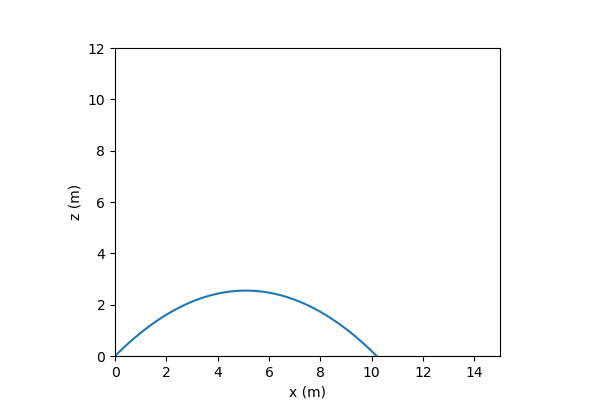

In [14]:
fig2, ax = plt.subplots(figsize=(6, 4))
# On définit les bornes des axes (en m)
ax.set_xlim(0, 15)
ax.set_ylim(0, 12)

# On fait en sorte que les deux axes aient la même échelle (afin que l'angle theta0 
# soit correctement « visible » sur le graphe)
ax.set_aspect('equal')

# On ajoute la légende des axes
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')

# On trace...
ax.plot(x, z)

# ...et on affiche
fig2.show()

In [15]:
matplotlib

Using matplotlib backend: nbAgg


In [16]:
%matplotlib

Using matplotlib backend: nbAgg


In [26]:
help(matplotlib)

NameError: name 'matplotlib' is not defined

In [28]:
!numpy.version.version

'numpy.version.version' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [29]:
import numpy

In [30]:
numpy.version.version

'1.16.2'

In [31]:
import ipywidgets

In [33]:
ipywidgets.version_info

(7, 4, 2, 'final', 0)